In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/sentiment-prediction-on-movie-reviews/movies.csv
/kaggle/input/sentiment-prediction-on-movie-reviews/sample.csv
/kaggle/input/sentiment-prediction-on-movie-reviews/train.csv
/kaggle/input/sentiment-prediction-on-movie-reviews/test.csv


# 1. Imports

In [2]:
import pandas as pd
from sklearn.dummy import DummyClassifier
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.pipeline import Pipeline
from sklearn.metrics import *
from sklearn import svm
from sklearn.naive_bayes import GaussianNB,BernoulliNB, MultinomialNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.svm import LinearSVC

# 2.  Data Loading

In [3]:
train = pd.read_csv('/kaggle/input/sentiment-prediction-on-movie-reviews/train.csv')
test = pd.read_csv('/kaggle/input/sentiment-prediction-on-movie-reviews/test.csv')

# 3. Exploratory Data Analysis (EDA)

In [4]:
train.head()

,movieid,reviewerName,isFrequentReviewer,reviewText,sentiment
0,marvelous_pirate,Benjamin Henry,False,Henry Selick’s first movie since 2009’s Corali...,POSITIVE
1,tony_montana_frodo_baggins_v_rocky_balboa,Felicia Lopez,False,With a cast that reads like the Vogue Oscar pa...,NEGATIVE
2,darth_vader_katniss_everdeen_sorcerer_donnie_d...,Mr. Charles Burgess,True,Creed II does not give us anything but another...,POSITIVE
3,lara_croft_glimmer,Ryan Barrett,False,"I know what you're thinking, but this is no Li...",POSITIVE
4,jason_bourne_surreal_the_terminator_indiana_jones,Alexander Glover,False,Director Fernando Meirelles tells the story wi...,POSITIVE


In [5]:
train.shape

(162758, 5)

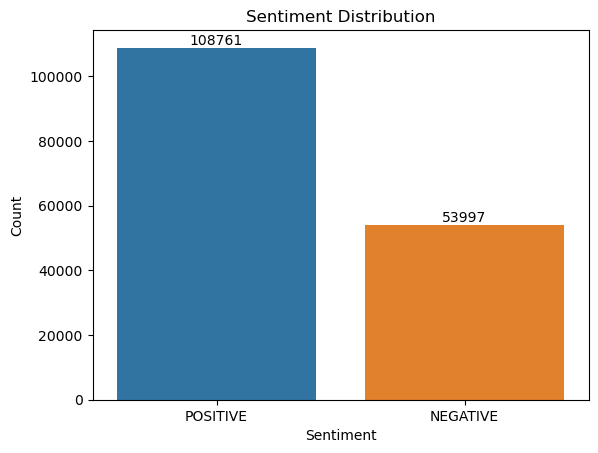

In [6]:
#Sentiment Distribution Plot
import matplotlib.pyplot as plt
import seaborn as sns

sentiment_counts = train['sentiment'].value_counts()

# Create a bar plot using seaborn's countplot
sns.countplot(x=train['sentiment'])

# Add labels to the bars
for index, value in enumerate(sentiment_counts):
    plt.text(index, value, str(value), ha='center', va='bottom')

# Set plot title and labels
plt.title('Sentiment Distribution')
plt.xlabel('Sentiment')
plt.ylabel('Count')

# Show the plot
plt.show()

In [7]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 162758 entries, 0 to 162757
Data columns (total 5 columns):
 #   Column              Non-Null Count   Dtype 
---  ------              --------------   ----- 
 0   movieid             162758 non-null  object
 1   reviewerName        162758 non-null  object
 2   isFrequentReviewer  162758 non-null  bool  
 3   reviewText          156311 non-null  object
 4   sentiment           162758 non-null  object
dtypes: bool(1), object(4)
memory usage: 5.1+ MB


In [8]:
train.dtypes

movieid               object
reviewerName          object
isFrequentReviewer      bool
reviewText            object
sentiment             object
dtype: object

In [9]:
train.describe().transpose()

,count,unique,top,freq
movieid,162758,16812,escape_the_terminator_tyler_durden_astonish,708
reviewerName,162758,4482,Sherri Morrison,962
isFrequentReviewer,162758,2,False,113189
reviewText,156311,155071,Parental Content Review,29
sentiment,162758,2,POSITIVE,108761


In [10]:
#Checking whether any null values in data
train.isnull().sum()

movieid                  0
reviewerName             0
isFrequentReviewer       0
reviewText            6447
sentiment                0
dtype: int64

# 4. Data Preprocessing

In [11]:
#Dropping the extra columns
train_df = train.drop(columns = ['movieid', 'reviewerName', 'isFrequentReviewer'])
train_df.head()

,reviewText,sentiment
0,Henry Selick’s first movie since 2009’s Corali...,POSITIVE
1,With a cast that reads like the Vogue Oscar pa...,NEGATIVE
2,Creed II does not give us anything but another...,POSITIVE
3,"I know what you're thinking, but this is no Li...",POSITIVE
4,Director Fernando Meirelles tells the story wi...,POSITIVE


In [12]:
#Text Preprocessing Step
import re

#Removing any special characters from ReviewText column using Regex library
train_df['reviewText'] = train_df['reviewText'].str.replace(r'[^a-zA-Z\s]', '', regex=True)
test['reviewText'] = test['reviewText'].str.replace(r'[^a-zA-Z\s]', '', regex=True)

#Converting review string to lowercase
train_df['reviewText'] = train_df['reviewText'].str.lower()
test['reviewText'] = test['reviewText'].str.lower()

#Handling null values
train_df['reviewText'] = train_df['reviewText'].fillna('')
test['reviewText'] = test['reviewText'].fillna('')

In [13]:
train_df.head()

,reviewText,sentiment
0,henry selicks first movie since s coraline his...,POSITIVE
1,with a cast that reads like the vogue oscar pa...,NEGATIVE
2,creed ii does not give us anything but another...,POSITIVE
3,i know what youre thinking but this is no limi...,POSITIVE
4,director fernando meirelles tells the story wi...,POSITIVE


In [14]:
#Converting sentiment labels to numerical values
train_df['sentiment'].replace({'POSITIVE': 1, 'NEGATIVE': 0}, inplace=True)
train_df.head()

,reviewText,sentiment
0,henry selicks first movie since s coraline his...,1
1,with a cast that reads like the vogue oscar pa...,0
2,creed ii does not give us anything but another...,1
3,i know what youre thinking but this is no limi...,1
4,director fernando meirelles tells the story wi...,1


In [15]:
X_train, y_train = train_df['reviewText'], train_df['sentiment']
X_test = test['reviewText']

In [16]:
y_train

0         1
1         0
2         1
3         1
4         1
         ..
162753    1
162754    0
162755    1
162756    0
162757    1
Name: sentiment, Length: 162758, dtype: int64

# 5. Models and Pipelines

In [17]:
#Vectorizers
count_vectorizer = CountVectorizer(stop_words='english')
tfidf_vectorizer = TfidfVectorizer(stop_words='english')

#Models
model1 = MultinomialNB()
model2 = LinearSVC()
model3 = LogisticRegression()

In [18]:
pipelines = [
    ('CountVectorizer_MultiNB', Pipeline([('vectorizer', count_vectorizer), ('classifier', MultinomialNB())])),
    ('TfidfVectorizer_MultiNB', Pipeline([('vectorizer', tfidf_vectorizer), ('classifier', MultinomialNB())])),
    ('CountVectorizer_LinearSVC', Pipeline([('vectorizer', count_vectorizer), ('classifier', LinearSVC())])),
    ('TfidfVectorizer_LinearSVC', Pipeline([('vectorizer', tfidf_vectorizer), ('classifier', LinearSVC())])),
    ('CountVectorizer_LogReg', Pipeline([('vectorizer', count_vectorizer), ('classifier', LogisticRegression(max_iter=1000))])),
    ('TfidfVectorizer_LogReg', Pipeline([('vectorizer', tfidf_vectorizer), ('classifier', LogisticRegression(max_iter=1000))]))
]

# 6. Cross Validation for selecting best model pipeline

In [19]:
from sklearn.model_selection import cross_val_score

cv_results = []
for pipeline_name, pipe in pipelines:
    scores = cross_val_score(pipe, X_train, y_train, cv=5)
    cv_results.append((pipeline_name, scores.mean()))

cv_results_df = pd.DataFrame(cv_results, columns = ['Model_Name', 'Accuracy'])
cv_results_df

,Model_Name,Accuracy
0,CountVectorizer_MultiNB,0.791193
1,TfidfVectorizer_MultiNB,0.744191
2,CountVectorizer_LinearSVC,0.768294
3,TfidfVectorizer_LinearSVC,0.786456
4,CountVectorizer_LogReg,0.789970
5,TfidfVectorizer_LogReg,0.792379


# 7. Hyperparameter Tuning for Best Model Parameters(Log Regression)

In [20]:
model = Pipeline([
    ('vectorizer', tfidf_vectorizer),
    ('classifier', LogisticRegression(max_iter=1000))
])

params = {
    'vectorizer__ngram_range': [(1, 1), (1, 2)],
    'classifier__C': [1, 5, 10],
    'classifier__solver': ['liblinear', 'sag', 'newton-cg'],
}

clf = GridSearchCV(model, params, cv=5, n_jobs=-1, scoring='f1')
clf.fit(X_train, y_train)

results_df = pd.DataFrame(clf.cv_results_)[['param_vectorizer__ngram_range', 'param_classifier__C', 'param_classifier__solver', 'mean_test_score']]

results_df

,param_vectorizer__ngram_range,param_classifier__C,param_classifier__solver,mean_test_score
0,"(1, 1)",1,liblinear,0.792391
1,"(1, 2)",1,liblinear,0.790622
2,"(1, 1)",1,sag,0.792367
3,"(1, 2)",1,sag,0.790634
4,"(1, 1)",1,newton-cg,0.792367
5,"(1, 2)",1,newton-cg,0.790640
6,"(1, 1)",5,liblinear,0.792643
7,"(1, 2)",5,liblinear,0.801675
8,"(1, 1)",5,sag,0.792643
9,"(1, 2)",5,sag,0.801669


In [21]:
print("Best Parameters:")
clf.best_params_

Best Parameters:


{'classifier__C': 10,
 'classifier__solver': 'sag',
 'vectorizer__ngram_range': (1, 2)}

In [22]:
print(f"Best Score: {clf.best_score_:.4f}")

Best Score: 0.8021


# 8. Running the best model on Test Data

In [23]:
model = clf.best_estimator_
y_pred = model.predict(X_test)

In [24]:
y_pred

array([1, 1, 1, ..., 0, 1, 0])

# 9. Dummy Classifier (Baseline Model)

In [43]:
# dummy_clf = DummyClassifier(strategy = "most_frequent")
# dummy_clf.fit(X_train, y_train)

DummyClassifier(strategy='most_frequent')

In [46]:
# y_pred = dummy_clf.predict(X_test)

In [ ]:
# accuracy_score(y_train, y_pred)

In [ ]:
# print(classification_report(y_train, y_pred))

# 10. Submitting a File

In [32]:
y_pred = np.where(y_pred==1, 'POSITIVE', 'NEGATIVE')
y_pred

array(['POSITIVE', 'POSITIVE', 'POSITIVE', ..., 'NEGATIVE', 'POSITIVE',
       'NEGATIVE'], dtype='<U8')

In [33]:
submission = pd.DataFrame(columns = ['id', 'sentiment'])
submission['id'] = [i for i in range(len(y_pred))]
submission['sentiment'] = y_pred
submission.to_csv('submission.csv', index=False)

In [34]:
sample = pd.read_csv('/kaggle/input/sentiment-prediction-on-movie-reviews/sample.csv')
sample.head()

,id,sentiment
0,0,NEGATIVE
1,1,NEGATIVE
2,2,NEGATIVE
3,3,NEGATIVE
4,4,NEGATIVE


In [35]:
submission.head()

,id,sentiment
0,0,POSITIVE
1,1,POSITIVE
2,2,POSITIVE
3,3,POSITIVE
4,4,POSITIVE
